How goal here is to estimate the impact of interacting experiments.  There is three things to investigate:

1. A regular old fashioned, ideally setup, A/B test with a binary outcome as a proof of principal

2. Several overlapping experiments which do not interfer with each other. We will be interested in understanding if we can accurately estimate their impact and what sample size we'll need

3. Two experiments, but one is a common cause of the treatment of the other experiment  

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
import graphviz as gr

from matplotlib import style

In [486]:
from linearmodels.iv import IV2SLS

In [2]:
sys.path.append('../../ab_testing_utils/')

In [3]:
import conversion_rate_utils

In [4]:
# set pandas preferences
pd.options.display.max_columns=500
pd.options.display.max_colwidth=500
pd.options.display.max_rows=500

In [5]:
# set plot style
style.use('fivethirtyeight')

### 1 simple A/B test

A test of conversion rates after being assigned to either treatment or control.  In this simulation, the treatment will have a positive impact with an average lift of 10% over the existing baseline from control which we will assume is, on average, 5%.  So:

1. Control conversion rate: 0.05

2. Treatment conversion rate: 0.055

This means that the minimum detectable effect size needs to be less than 10%, let's peg it at a relative 8%.  Also assume that we get about 10,000 vistors per day, on average

The first question, how long will the experiment take to run?

In [6]:
simple_ab = conversion_rate_utils.ConversionExperiment()

In [7]:
daily_num_observations = 10000
monthly_num_observations = daily_num_observations * 7 * 4
baseline_conversion_rate = 0.05

In [8]:
df_mde_ab = simple_ab.create_mde_table(monthly_num_obs=monthly_num_observations,baseline_conversion_rate=baseline_conversion_rate)

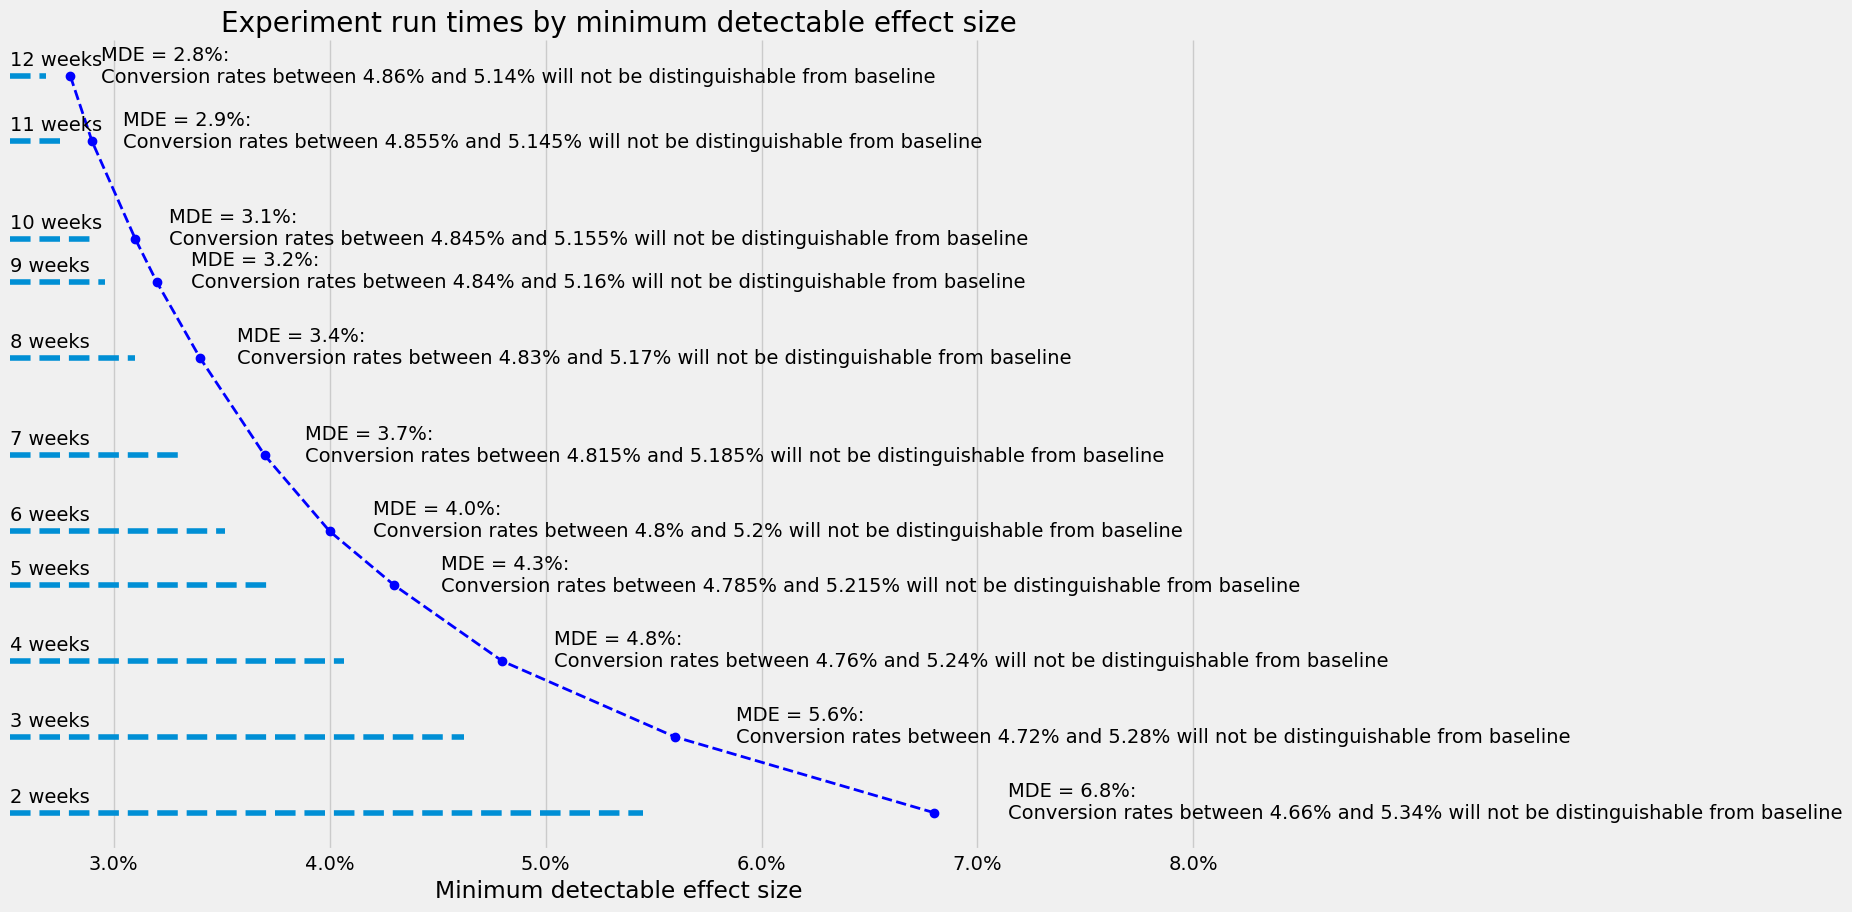

In [9]:
simple_ab.make_mde_plot(df_=df_mde_ab, min_weeks=2, max_weeks=12, figsize=(14, 10))

So, with two weeks worth of data, we should be able to estimate the impact we want.  

First, let's generate some daily level number of observations. We'll do this at first with a poisson distribution with mean 10,000 which means a standard deviation of 100

We'll also try to simulate wide variances on our population stats, this will simulate cases where we actually have a wide variation, day, to day, to our website and why seasonal effects are important when estimating sample sizes/runtimes (this is why we always run experiments for at least 2 business cycles). We'll do this later with a negative binomial distribution as the Possion has a fixed variance based on the mean, so we can't really adjust our expectations much.  We'll select from a negative binomial distribution with mean 10,000 and standard deviation of about 300. 

In [10]:
number_of_weeks_for_experiment = 2
number_of_days_for_experiment = number_of_weeks_for_experiment * 7

In [11]:
daily_units = []
day_list = []
for i in range(number_of_days_for_experiment):
    day_ = str(i)
    number_of_observations = np.random.poisson(daily_num_observations)
    observations = [1] * number_of_observations
    daily_units = daily_units + observations
    day_index = [day_] * number_of_observations
    day_list = day_list + day_index

In [12]:
df_ab = pd.DataFrame()
df_ab['day'] = day_list
df_ab['units'] = daily_units

In [13]:
df_ab.head()

,day,units
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


In [14]:
# Now we need to do random assignment
def assign_randomly(df, p=0.5):
    df_ = df.copy()
    df_g = df_.groupby('day', as_index=False).sum()
    assignment = []
    for day_, num_obs in zip(df_g['day'].unique(), df_g['units'].unique()):
        assignments_ = np.random.binomial(n=1, p=0.5, size=num_obs)
        assignment = assignment + list(assignments_)
    df_['group'] = assignment
    df_['group'] = df_['group'].apply(lambda x: 'treatment' if x == 1 else 'control')
    
    return df_

In [15]:
df_ab = assign_randomly(df_ab)

In [16]:
df_ab.head()

,day,units,group
0,0,1,control
1,0,1,treatment
2,0,1,treatment
3,0,1,treatment
4,0,1,treatment


In [17]:
df_ab[['day', 'group']].groupby('day').value_counts(normalize=True)

day  group    
0    treatment    0.501351
     control      0.498649
1    control      0.502462
     treatment    0.497538
10   treatment    0.501512
     control      0.498488
11   treatment    0.502356
     control      0.497644
12   treatment    0.501159
     control      0.498841
13   control      0.503160
     treatment    0.496840
2    control      0.502384
     treatment    0.497616
3    control      0.501766
     treatment    0.498234
4    treatment    0.501395
     control      0.498605
5    treatment    0.502684
     control      0.497316
6    control      0.502816
     treatment    0.497184
7    treatment    0.509273
     control      0.490727
8    control      0.506245
     treatment    0.493755
9    treatment    0.502623
     control      0.497377
dtype: float64

In [18]:
# Looks about right
df_ab['group'].value_counts(normalize=True)

treatment    0.500251
control      0.499749
Name: group, dtype: float64

In [19]:
# Close enough. Now we need to generate conversion rates at the simulated rates for both control and treatment groups
def generate_conversions(df, control_p, treatment_p, treatment_name, group_col='group'):
    df_ = df.copy()
    conversions = []
    for n in df_[group_col].values:
        if n == treatment_name:
            p_ = treatment_p
        else:
            p_ = control_p
        conv_ = np.random.binomial(n=1, p=p_)
        conversions.append(conv_)
    
    df_['conversion'] = conversions
    
    return df_

In [20]:
df_ab = generate_conversions(df=df_ab, control_p=baseline_conversion_rate, treatment_p=baseline_conversion_rate + 0.1*baseline_conversion_rate, treatment_name='treatment')

In [21]:
df_ab.head()

,day,units,group,conversion
0,0,1,control,0
1,0,1,treatment,0
2,0,1,treatment,0
3,0,1,treatment,0
4,0,1,treatment,0


In [22]:
df_ab_results = df_ab[['group', 'units', 'conversion']].groupby('group', as_index=False).sum()

In [23]:
df_ab_results.head()

,group,units,conversion
0,control,69614,3501
1,treatment,69684,3747


In [24]:
df_ab_results['conversion_rate'] = df_ab_results['conversion'] / df_ab_results['units']

In [25]:
df_ab_results

,group,units,conversion,conversion_rate
0,control,69614,3501,0.050292
1,treatment,69684,3747,0.053771


In [26]:
# Is this a significant result?
z_score, p_value = sm.stats.proportions_ztest([df_ab_results.query("group=='control'")['conversion'].values, df_ab_results.query("group=='treatment'")['conversion'].values], 
                                              [df_ab_results.query("group=='control'")['units'].values, df_ab_results.query("group=='treatment'")['units'].values])

In [27]:
z_score

array([-2.92382307])

In [28]:
# Note that this is the same as doing a 2 variant Chi-squared test
p_value

array([0.00345761])

In [29]:
# So yes, this is statistically signifcant to our desired level of confidence 95% :) 

In [30]:
lift = (df_ab_results.query("group=='treatment'")['conversion_rate'].iloc[0] - df_ab_results.query("group=='control'")['conversion_rate'].iloc[0]) / df_ab_results.query("group=='control'")['conversion_rate'].iloc[0]

In [31]:
lift = lift * 100

In [32]:
lift

6.919051935615143

This is inline with our MDE.  Note that it is possible for us to detect a statistically significant difference that is smaller than our MDE, it' just less probable the smaller the effect gets, and we cannot be reliably confident that we would be able to detect it in the first place. 

In [33]:
df_ab_results.query("group=='treatment'").head()

,group,units,conversion,conversion_rate
1,treatment,69684,3747,0.053771


In [34]:
# We'll compute a 95% confidence interval as well. We'll treat this as a Bernoulli random variable. We could probably also bootstrap this
sigma_treated = df_ab_results.query("group=='treatment'")['conversion_rate'].iloc[0] * (1 - df_ab_results.query("group=='treatment'")['conversion_rate'].iloc[0])
treatment_sample_size = df_ab_results.query("group=='treatment'")['units'].iloc[0]

In [35]:
se_treated = np.sqrt(sigma_treated / treatment_sample_size)

In [36]:
treated_lower_ci_95 = df_ab_results.query("group=='treatment'")['conversion_rate'].iloc[0] - 1.96 * se_treated
treated_upper_ci_95 = df_ab_results.query("group=='treatment'")['conversion_rate'].iloc[0] + 1.96 * se_treated

In [37]:
# And for the control measurement:
sigma_control = df_ab_results.query("group=='control'")['conversion_rate'].iloc[0] * (1 - df_ab_results.query("group=='control'")['conversion_rate'].iloc[0])
control_sample_size = df_ab_results.query("group=='control'")['units'].iloc[0]
se_control = np.sqrt(sigma_control / control_sample_size)
control_lower_ci_95 = df_ab_results.query("group=='control'")['conversion_rate'].iloc[0] - 1.96 * se_control
control_upper_ci_95 = df_ab_results.query("group=='control'")['conversion_rate'].iloc[0] + 1.96 * se_control

In [38]:
df_ab_results['lower_ci_95'] = [control_lower_ci_95, treated_lower_ci_95]
df_ab_results['upper_ci_95'] = [control_upper_ci_95, treated_upper_ci_95]

In [39]:
df_ab_results

,group,units,conversion,conversion_rate,lower_ci_95,upper_ci_95
0,control,69614,3501,0.050292,0.048668,0.051915
1,treatment,69684,3747,0.053771,0.052097,0.055446


In [40]:
# And that should be it. 

### 2 simulate two experiments which do not interfer:

This means that, even though units can be assigned to both experiments randomly, they do not interfer in that one experiment cannot cause the treatment of another. In this case we expect the results to "average out".

Effectively, this means that we'll just simulate the experiment we did above twice. We'll assume one experiment has a lift of 10% while the other has a lift of -15% (say it was really negative)

In [41]:
daily_units = []
day_list = []
for i in range(number_of_days_for_experiment):
    day_ = str(i)
    number_of_observations = np.random.poisson(daily_num_observations)
    observations = [1] * number_of_observations
    daily_units = daily_units + observations
    day_index = [day_] * number_of_observations
    day_list = day_list + day_index

In [42]:
df_ab = pd.DataFrame()
df_ab['day'] = day_list
df_ab['units'] = daily_units

In [43]:
df_ab = assign_randomly(df_ab)

In [44]:
df_ab.head()

,day,units,group
0,0,1,treatment
1,0,1,control
2,0,1,treatment
3,0,1,control
4,0,1,treatment


In [45]:
df_ab = df_ab.rename(index=str, columns={'group': 'group_exp_1'})

In [46]:
df_ab = assign_randomly(df_ab)

In [47]:
df_ab = df_ab.rename(index=str, columns={'group': 'group_exp_2'})

In [48]:
df_ab = generate_conversions(df=df_ab, 
                             control_p=baseline_conversion_rate, 
                             treatment_p=baseline_conversion_rate + 0.1*baseline_conversion_rate, 
                             treatment_name='treatment', 
                             group_col='group_exp_1')

In [49]:
df_ab.head()

,day,units,group_exp_1,group_exp_2,conversion
0,0,1,treatment,treatment,0
1,0,1,control,control,0
2,0,1,treatment,control,0
3,0,1,control,treatment,0
4,0,1,treatment,treatment,0


In [50]:
df_ab = df_ab.rename(index=str, columns={'conversion': 'conversion_exp_1'})

In [51]:
df_ab = generate_conversions(df=df_ab, 
                             control_p=baseline_conversion_rate, 
                             treatment_p=baseline_conversion_rate - 0.15*baseline_conversion_rate, 
                             treatment_name='treatment', 
                             group_col='group_exp_2')

In [52]:
df_ab = df_ab.rename(index=str, columns={'conversion': 'conversion_exp_2'})

In [53]:
df_ab.head()

,day,units,group_exp_1,group_exp_2,conversion_exp_1,conversion_exp_2
0,0,1,treatment,treatment,0,0
1,0,1,control,control,0,0
2,0,1,treatment,control,0,0
3,0,1,control,treatment,0,0
4,0,1,treatment,treatment,0,0


We'll measure the impact of experiment 1, and then experiment 2, separately just like we would do in reality.  We'll also try a multiple hypothesis testing scheme to distinguish each experiment. 

In [54]:
df_ab_results_exp_1 = df_ab[['group_exp_1', 'units', 'conversion_exp_1']].groupby('group_exp_1', as_index=False).sum()
df_ab_results_exp_2 = df_ab[['group_exp_2', 'units', 'conversion_exp_2']].groupby('group_exp_2', as_index=False).sum()

In [55]:
df_ab_results_exp_1['conversion_rate'] = df_ab_results_exp_1['conversion_exp_1'] / df_ab_results_exp_1['units']
df_ab_results_exp_2['conversion_rate'] = df_ab_results_exp_2['conversion_exp_2'] / df_ab_results_exp_2['units']

In [56]:
# z_score_exp_1, p_value_exp_1 = sm.stats.proportions_ztest([df_ab_results_exp_1.query("group_exp_1=='control'")['conversion_exp_1'].values, 
#                                                            df_ab_results_exp_1.query("group_exp_1=='treatment'")['conversion_exp_1'].values], 
#                                                           [df_ab_results_exp_1.query("group_exp_1=='control'")['units'].values, 
#                                                            df_ab_results_exp_1.query("group_exp_1=='treatment'")['units'].values])
exp_1_test = sm.stats.proportions_ztest([df_ab_results_exp_1.query("group_exp_1=='control'")['conversion_exp_1'].values, 
                                                           df_ab_results_exp_1.query("group_exp_1=='treatment'")['conversion_exp_1'].values], 
                                                          [df_ab_results_exp_1.query("group_exp_1=='control'")['units'].values, 
                                                           df_ab_results_exp_1.query("group_exp_1=='treatment'")['units'].values])

In [57]:
# z_score_exp_2, p_value_exp_2 = sm.stats.proportions_ztest([df_ab_results_exp_2.query("group_exp_2=='control'")['conversion_exp_2'].values, 
#                                                            df_ab_results_exp_2.query("group_exp_2=='treatment'")['conversion_exp_2'].values], 
#                                                           [df_ab_results_exp_2.query("group_exp_2=='control'")['units'].values, 
#                                                            df_ab_results_exp_2.query("group_exp_2=='treatment'")['units'].values])
exp_2_test = sm.stats.proportions_ztest([df_ab_results_exp_2.query("group_exp_2=='control'")['conversion_exp_2'].values, 
                                                           df_ab_results_exp_2.query("group_exp_2=='treatment'")['conversion_exp_2'].values], 
                                                          [df_ab_results_exp_2.query("group_exp_2=='control'")['units'].values, 
                                                           df_ab_results_exp_2.query("group_exp_2=='treatment'")['units'].values])

In [58]:
exp_1_test[1]

array([0.00109184])

In [59]:
exp_2_test[1]

array([1.21370277e-15])

In [60]:
df_ab_results_exp_1

,group_exp_1,units,conversion_exp_1,conversion_rate
0,control,70572,3469,0.049155
1,treatment,70455,3733,0.052984


In [61]:
df_ab_results_exp_2

,group_exp_2,units,conversion_exp_2,conversion_rate
0,control,70593,3508,0.049693
1,treatment,70434,2876,0.040833


In [62]:
lift_exp_1 = ((0.053955 - 0.050250)/0.050250) * 100

In [63]:
lift_exp_2 = ((0.042554 - 0.049864) / 0.049864) * 100

In [64]:
lift_exp_1

7.373134328358208

In [65]:
lift_exp_2

-14.659874859618155

In [66]:
# So we're able to measure the significance here, and the two experiments had no effect on each other. Can we compare all of them? 
# We've already compared treatment 1 and 2 to the control. Not sure this really makes sense, might be more suitable when there are multiple variants
# exp_1_vs_2 = sm.stats.proportions_ztest([df_ab_results_exp_2.query("group_exp_2=='control'")['conversion_exp_2'].values, 
#                                                            df_ab_results_exp_2.query("group_exp_2=='treatment'")['conversion_exp_2'].values], 
#                                                           [df_ab_results_exp_2.query("group_exp_2=='control'")['units'].values, 
#                                                            df_ab_results_exp_2.query("group_exp_2=='treatment'")['units'].values])

### 3: 2 experiments, one is a common cause of the other

Let's say one experiment has a positive effect, call it +7%, in line with our MDE, while the second experiment has a negative effect of -10%.

We'll also say that the second experiment can interfer with the first,  causing the treatment (or lack thereof).  

Let's say that those in treatment in both experiments get a -50% lift in conversion rate due to a bad experience

In [400]:
daily_units = []
day_list = []
for i in range(number_of_days_for_experiment):
    day_ = str(i)
    number_of_observations = np.random.poisson(daily_num_observations)
    observations = [1] * number_of_observations
    daily_units = daily_units + observations
    day_index = [day_] * number_of_observations
    day_list = day_list + day_index

In [401]:
df_ab = pd.DataFrame()
df_ab['day'] = day_list
df_ab['units'] = daily_units

In [402]:
df_ab = assign_randomly(df_ab)

In [403]:
df_ab = df_ab.rename(index=str, columns={'group': 'group_exp_1'})

In [404]:
df_ab = assign_randomly(df_ab)

In [405]:
df_ab = df_ab.rename(index=str, columns={'group': 'group_exp_2'})

In [406]:
df_ab.head()

,day,units,group_exp_1,group_exp_2
0,0,1,treatment,control
1,0,1,treatment,treatment
2,0,1,treatment,treatment
3,0,1,treatment,treatment
4,0,1,control,treatment


In [407]:
def generate_interferring_conversion(df, control_p, treatment_p, treatment_name_exp_1='treatment',  treatment_name_exp_2='treatment', group_col_exp_1='group_exp_1', group_col_exp_2='group_exp_2', interference_prob=1.0):
    df_ = df.copy()
    conversions = []

    for g1, g2 in zip(df_[group_col_exp_1].values, df_[group_col_exp_2].values):
        if g1 == treatment_name_exp_1 and g2 != treatment_name_exp_2:
            # This group is in the treatment group for experiment one, and control for experiment 2
            p_ = treatment_p
        elif g1 != treatment_name_exp_1 and g2 != treatment_name_exp_2:
            # This group is in the control groups for experiments 1 and 2
            p_ = control_p
        elif g1 != treatment_name_exp_1 and g2 == treatment_name_exp_2:
            # This group is in the control for experiment 1 and treatment for experiment 2.
            # We'll assume that the control experience is not impacted by the treatment in experiment 2
            p_ = control_p
        else:
            # This group is in the treatment for experiments 1 and 2. These will interfer
            # We'll model interference as a kind of non-compliance:
            gets_interference = np.random.binomial(n=1, p=interference_prob)
            
            if gets_interference == 1:
               #  p_ = control_p
                p_ = control_p - 0.5*control_p
            else:
                p_ = treatment_p
            
        conv_ = np.random.binomial(n=1, p=p_)
        conversions.append(conv_)
        
    df_['conversion'] = conversions
        
    return df_

In [408]:
# So if someone is in the treatment group for experiment one and experiment two, there is some chance (50% in this case) that the person will never actually see the treatment from
# experiment one and just go straight through to experiment two.
# Experiment two is unaffected
df_ab = generate_conversions(df=df_ab, 
                             control_p=baseline_conversion_rate, 
                             treatment_p=baseline_conversion_rate + -0.1*baseline_conversion_rate, 
                             treatment_name='treatment', 
                             group_col='group_exp_2')

In [409]:
df_ab = df_ab.rename(index=str, columns={'conversion': 'conversion_exp_2'})

In [410]:
df_ab = generate_interferring_conversion(df=df_ab, control_p=baseline_conversion_rate, treatment_p=baseline_conversion_rate + 0.07*baseline_conversion_rate)

In [411]:
df_ab = df_ab.rename(index=str, columns={'conversion': 'conversion_exp_1'})

In [412]:
# Normally, we'd try and measure the impact of each experiment separately:
df_ab_results_exp_1 = df_ab[['group_exp_1', 'units', 'conversion_exp_1']].groupby('group_exp_1', as_index=False).sum()
df_ab_results_exp_2 = df_ab[['group_exp_2', 'units', 'conversion_exp_2']].groupby('group_exp_2', as_index=False).sum()

In [413]:
df_ab_results_exp_1['conversion_rate'] = df_ab_results_exp_1['conversion_exp_1'] / df_ab_results_exp_1['units']
df_ab_results_exp_2['conversion_rate'] = df_ab_results_exp_2['conversion_exp_2'] / df_ab_results_exp_2['units']

In [414]:
exp_1_test = sm.stats.proportions_ztest([df_ab_results_exp_1.query("group_exp_1=='control'")['conversion_exp_1'].values, 
                                                           df_ab_results_exp_1.query("group_exp_1=='treatment'")['conversion_exp_1'].values], 
                                                          [df_ab_results_exp_1.query("group_exp_1=='control'")['units'].values, 
                                                           df_ab_results_exp_1.query("group_exp_1=='treatment'")['units'].values])

In [415]:
exp_2_test = sm.stats.proportions_ztest([df_ab_results_exp_2.query("group_exp_2=='control'")['conversion_exp_2'].values, 
                                                           df_ab_results_exp_2.query("group_exp_2=='treatment'")['conversion_exp_2'].values], 
                                                          [df_ab_results_exp_2.query("group_exp_2=='control'")['units'].values, 
                                                           df_ab_results_exp_2.query("group_exp_2=='treatment'")['units'].values])

In [416]:
experiment_1_p_value = exp_1_test[1]
experiment_2_p_value = exp_2_test[1]

In [417]:
experiment_1_p_value

array([3.33005362e-18])

In [418]:
experiment_2_p_value

array([1.86883508e-09])

In [419]:
df_ab_results_exp_1

,group_exp_1,units,conversion_exp_1,conversion_rate
0,control,70204,3468,0.049399
1,treatment,70321,2800,0.039817


In [420]:
lift_1 = ((df_ab_results_exp_1.query("group_exp_1=='treatment'")['conversion_rate'].values[0] - df_ab_results_exp_1.query("group_exp_1=='control'")['conversion_rate'].values[0]) / df_ab_results_exp_1.query("group_exp_1=='control'")['conversion_rate'].values[0]) * 100

In [421]:
df_ab_results_exp_2

,group_exp_2,units,conversion_exp_2,conversion_rate
0,control,70403,3577,0.050807
1,treatment,70122,3085,0.043995


In [422]:
lift_1 = ((df_ab_results_exp_2.query("group_exp_2=='treatment'")['conversion_rate'].values[0] - df_ab_results_exp_2.query("group_exp_2=='control'")['conversion_rate'].values[0]) / df_ab_results_exp_2.query("group_exp_2=='control'")['conversion_rate'].values[0]) * 100

In [423]:
lift_1

-13.408931358316298

In [424]:
lift_2

-7.574684978054648

So in this extreme example, the first experiment looks to be driving an extremely negative, and very statistically signifcant, decrease in lift. 

The second experiment, which had no interference comes out as expected with a correct estimate of the true effect

In [425]:
df_results_all = df_ab[['group_exp_1', 'group_exp_2', 'units', 'conversion_exp_2', 'conversion_exp_1']].groupby(['group_exp_1', 'group_exp_2'], as_index=False).agg({'units': 'count', 'conversion_exp_2': 'sum', 'conversion_exp_1': 'sum'})

In [426]:
df_results_all

,group_exp_1,group_exp_2,units,conversion_exp_2,conversion_exp_1
0,control,control,35131,1797,1692
1,control,treatment,35073,1565,1776
2,treatment,control,35272,1780,1892
3,treatment,treatment,35049,1520,908


So the question is, can we actually detect the true effect from the first experiment? Let's see.  We'd only be able to run this on those who were in control in experiment 1 and treatment in experiment 1 + control in experiment 2

In [427]:
sample_size_control = df_results_all.query("group_exp_1=='control'")['units'].sum()
sample_size_treatment = df_results_all.query("group_exp_1=='treatment'").query("group_exp_2=='control'")['units'].sum()
conversions_control = df_results_all.query("group_exp_1=='control'")['conversion_exp_1'].sum()
conversions_treatment = df_results_all.query("group_exp_1=='treatment'").query("group_exp_2=='control'")['conversion_exp_1'].sum()

In [428]:
conversion_rate_control = conversions_control / sample_size_control
conversion_rate_treatment = conversions_treatment / sample_size_treatment

In [429]:
conversion_rate_control

0.0493988946498775

In [430]:
conversion_rate_treatment

0.05364028124291222

In [431]:
lift_on_treated = ((conversion_rate_treatment - conversion_rate_control) / conversion_rate_control) * 100

In [432]:
lift_on_treated

8.585994935911472

In [433]:
sm.stats.proportions_ztest([conversions_control, conversions_treatment], [sample_size_control, sample_size_treatment])

(-2.9590105735321464, 0.003086285117363539)

So this estimates a lift of 8.6% on the treated. This isn't the same as the treatment effect. If we believe that this generalizes and that the bad experience was just random, then we can claim that this is the effect and it is statistically significant.  However, if the bad experience was not random, but rather due to a confounder, then we're in trouble. We always got really lucky that we had sufficient sample size here to say anything at all! 

Note that treating experiment one separately and just measuring the difference in outcomes between treated and control is not actually answering the question we expect it to.  It's not answering: "What is the causal effect of my treatment". Due to non-compliance, it's answering the question "What is the causal effect of treatment assignment", these are different. Due to the non-compliance negative effect, the estimate we get from this approach will always be biased towards zero, as we saw.  

### A somewhat more complex example

Suppose we run an A/B test on a surface with a baseline conversion rate of 2%. We expect our experiment to provide a relative lift in conversion of 11%, on average, but it could be higher.  

Suppose as well that we have two types of users, those coming from Android, and those coming from iOS.  At the same time, we run a separate experiment on only iOS users.  Suppose that this experiment is quite harmful (say, it has a bug or something) such that it blocks the treatment of experiment 1 for users on an older version of iOS.

Let's say our population breaksdown like this:

Say we get 5,000 vistors per day.  75% are on iOS and 25% are on Android, on average. 

We'll also say that 50% of iOS users are using the old version that causes the weird bug in experiment 1. This is an extreme example, but this should help drive the message home. We want to be able to see something dramatic to exemplify the effect. 

In this example, the interaction between experiments is NOT random.  Even though we will randomly assign users, there is a confounder between the outcome of experiment 1 and its outcome: assignment to experiment 2 AND which version of iOS you have installed.  We might expect that the iOS version is not random, but rather reflects something about the population that is using the older version (perhaps they are less wealthy and so are using an older phone, for example). 

So let's go ahead and design our experiments as per usual. We'll also assume that conversion rate amongst iOS users is, on average, about 3%

In [817]:
exp_1 = conversion_rate_utils.ConversionExperiment()
exp_iOS = conversion_rate_utils.ConversionExperiment()

In [818]:
daily_num_observations = 5000
daily_num_iOS = int(daily_num_observations * 0.75)
monthly_num_observations = daily_num_observations * 7 * 4
monthly_num_observations_iOS = daily_num_iOS * 7 * 4
baseline_conversion_rate = 0.02
baseline_iOS = 0.03

In [819]:
df_mde_exp_1 = exp_1.create_mde_table(monthly_num_obs=monthly_num_observations, baseline_conversion_rate=baseline_conversion_rate)
df_mde_iOS = exp_iOS.create_mde_table(monthly_num_obs=monthly_num_observations_iOS, baseline_conversion_rate=baseline_iOS)

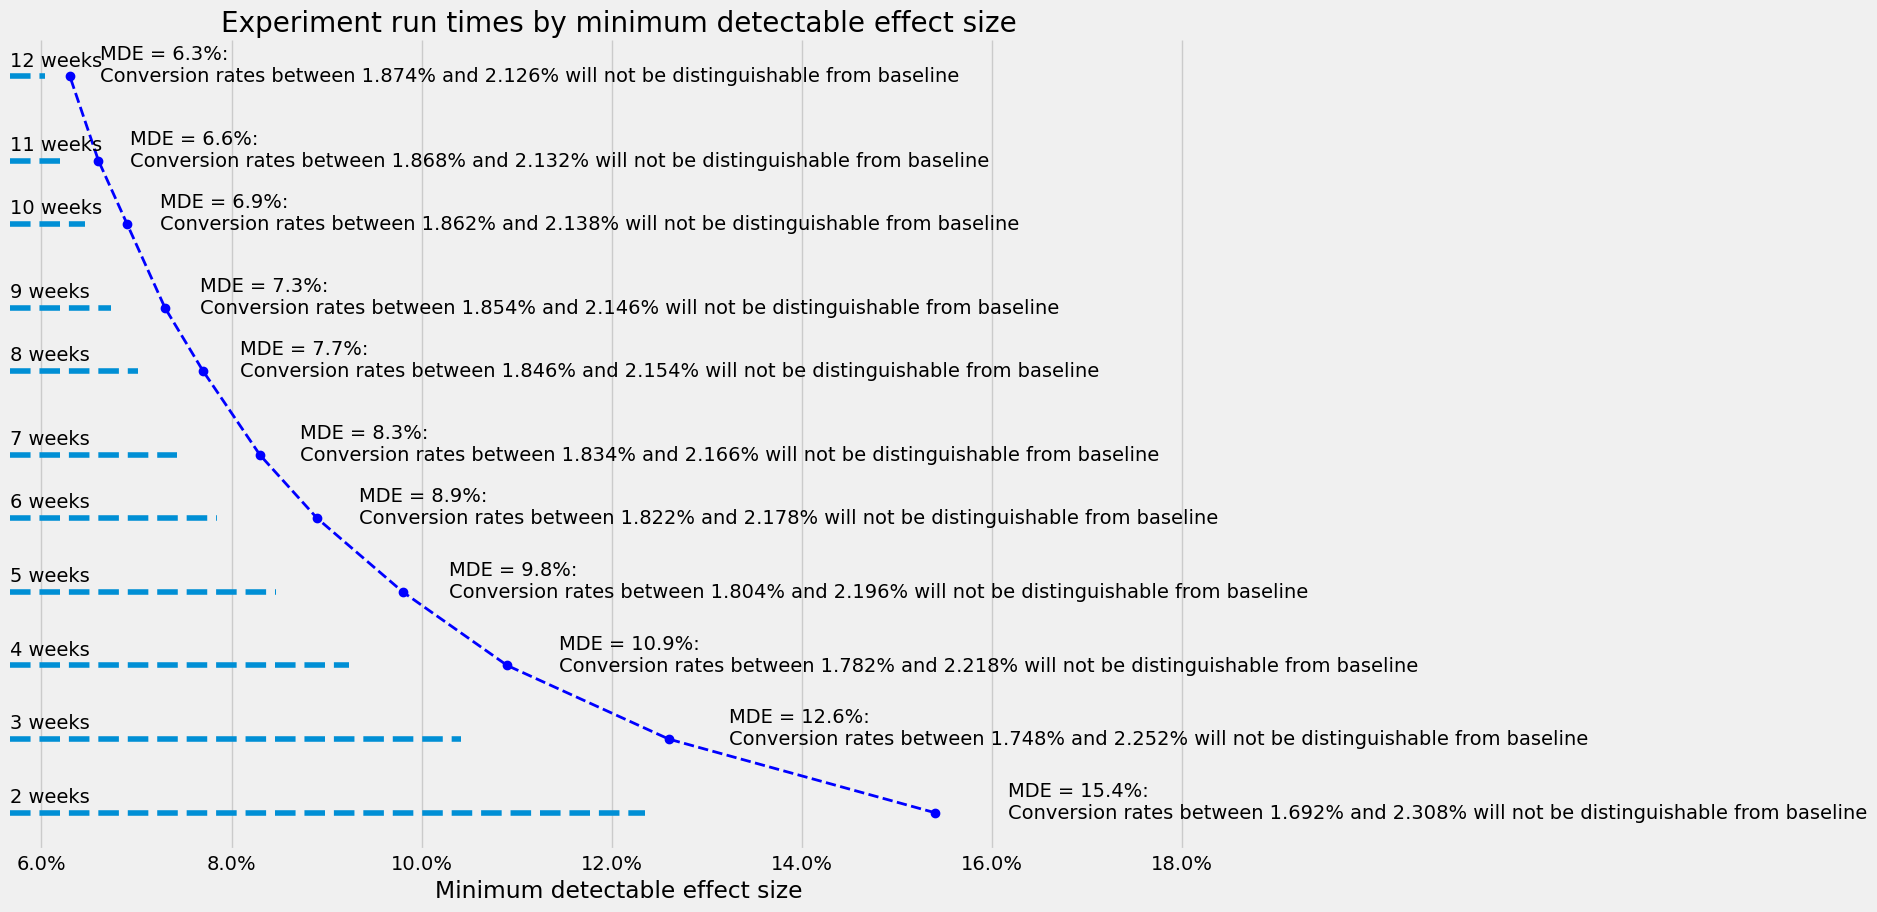

In [820]:
exp_1.make_mde_plot(df_=df_mde_exp_1, min_weeks=2, max_weeks=12, figsize=(14, 10))

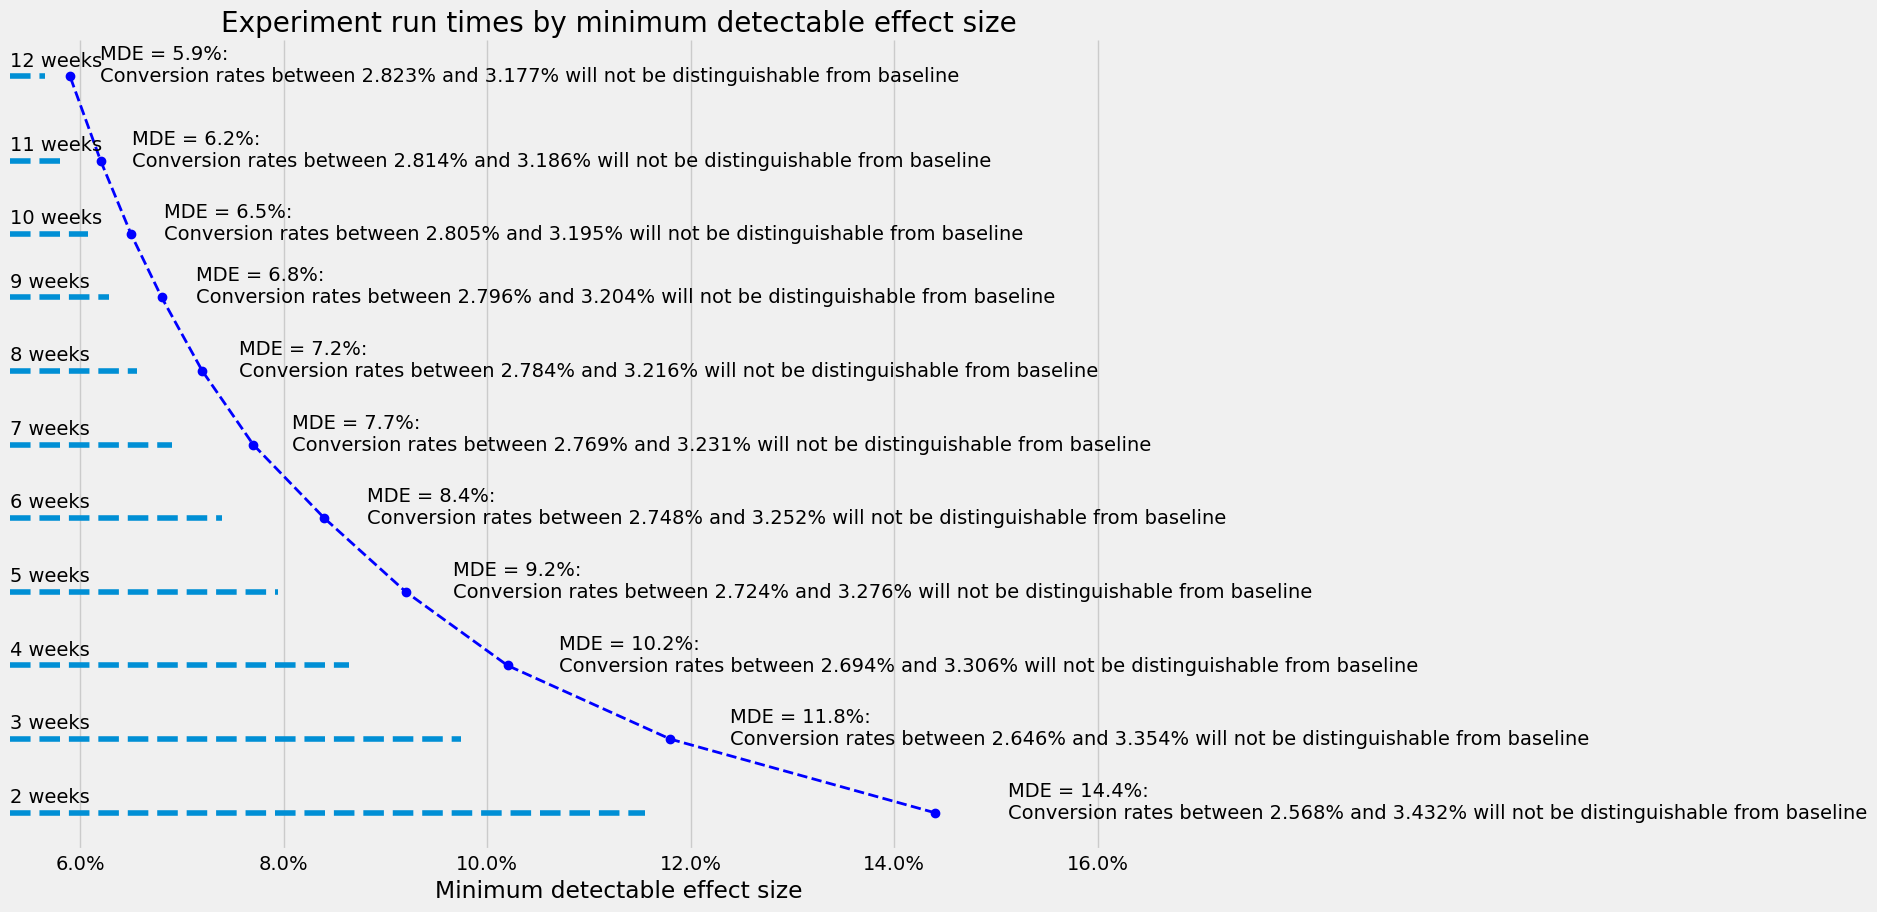

In [821]:
exp_iOS.make_mde_plot(df_=df_mde_iOS, min_weeks=2, max_weeks=12, figsize=(14, 10))

So for both experiments, let's say we settle on 4 weeks of runtime. 

In [941]:
number_of_weeks_for_experiment = 4
number_of_days_for_experiment = number_of_weeks_for_experiment * 7

In [996]:
def generate_population_sample(daily_num_observations):
    daily_units = []
    day_list = []
    for i in range(number_of_days_for_experiment):
        day_ = str(i)
        number_of_observations = np.random.poisson(daily_num_observations)
        observations = [1] * number_of_observations
        daily_units = daily_units + observations
        day_index = [day_] * number_of_observations
        day_list = day_list + day_index
    
    return daily_units, day_list

In [997]:
daily_units_exp_1, day_list_exp_1 = generate_population_sample(daily_num_observations=daily_num_observations)

In [998]:
df_ab = pd.DataFrame()
df_ab['day'] = day_list
df_ab['units'] = daily_units

In [999]:
df_ab.head()

,day,units
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


In [1049]:
# Ok now we need to assign OS types to each. There are 2: iOS = 75% of sample, on average, Android = 25% of sample on average
def assign_os(df):
    df_ = df.copy()
    
    os_ = []
    for unit in df_['units'].values:
        _ = np.random.binomial(n=1, p=0.75)
        if _ == 1:
            # We also need to assign the iOS version. There is old and new. Old should be about 50% of the sample, on average
            v = np.random.binomial(n=1, p=0.5)
            if v == 1:
                os_.append('iOS_old')
            else:
                os_.append('iOS_new')
        else:
            os_.append('Android')
    
    df_['os'] = os_
    
    return df_

In [1001]:
df_ab = assign_os(df=df_ab)

In [1002]:
df_ab.head()

,day,units,os
0,0,1,Android
1,0,1,Android
2,0,1,iOS_new
3,0,1,iOS_new
4,0,1,iOS_new


In [1003]:
df_ab['is_old_ios'] = df_ab['os'].apply(lambda x: 1 if x == 'iOS_old' else 0)

In [1004]:
df_ab.head()

,day,units,os,is_old_ios
0,0,1,Android,0
1,0,1,Android,0
2,0,1,iOS_new,0
3,0,1,iOS_new,0
4,0,1,iOS_new,0


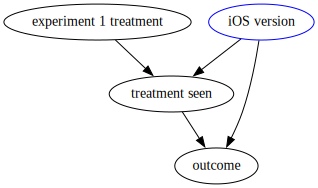

In [1005]:
# So here's the model I have in mind for this:
g = gr.Digraph()

g.edge("experiment 1 treatment", "treatment seen")
g.edge("treatment seen", "outcome")
g.edge("iOS version", "outcome")
g.edge("iOS version", "treatment seen")
g.node("iOS version", color="blue")
g

In [1006]:
# First we need to assign treatment and control
assignment = np.random.binomial(n=1, p=0.5, size=df_ab.shape[0])

In [1007]:
df_ab['assignment'] = assignment

In [1008]:
df_ab['assignment'] = df_ab['assignment'].apply(lambda x: 'treatment' if x == 1 else 'control')

In [1009]:
df_ab['assignment'].value_counts(normalize=True)

control      0.501633
treatment    0.498367
Name: assignment, dtype: float64

In [1010]:
df_ab.head()

,day,units,os,is_old_ios,assignment
0,0,1,Android,0,control
1,0,1,Android,0,control
2,0,1,iOS_new,0,treatment
3,0,1,iOS_new,0,treatment
4,0,1,iOS_new,0,treatment


In [1011]:
def make_conversion_rates_by_os(df, control_p, treatment_p):
    df_ = df.copy()
    conversions = []
    for assignment, ios in zip(df_['assignment'].values, df_['is_old_ios'].values):
        if assignment == 'control':
            conv_ = np.random.binomial(n=1, p=control_p)
        else:
            if ios == 1:
                conv_ = np.random.binomial(n=1, p=control_p)
                # conv_ = 0
                # conv_ = np.random.binomial(n=1, p=0.001)
            else:
                conv_ = np.random.binomial(n=1, p=treatment_p)
        
        conversions.append(conv_)
    
    df_['conversions'] = conversions
    
    return df_

In [1012]:
df_ab = make_conversion_rates_by_os(df=df_ab, control_p=baseline_conversion_rate, treatment_p=baseline_conversion_rate + 0.11*baseline_conversion_rate)

In [1013]:
baseline_conversion_rate + 0.11*baseline_conversion_rate

0.0222

In [1014]:
df_ab.head()

,day,units,os,is_old_ios,assignment,conversions
0,0,1,Android,0,control,0
1,0,1,Android,0,control,0
2,0,1,iOS_new,0,treatment,0
3,0,1,iOS_new,0,treatment,0
4,0,1,iOS_new,0,treatment,0


In [1015]:
df_ab['os'].value_counts(normalize=True)

iOS_new    0.377428
iOS_old    0.375122
Android    0.247451
Name: os, dtype: float64

In [1016]:
df_ab_results= df_ab[['assignment', 'units', 'conversions']].groupby('assignment', as_index=False).sum()

In [1017]:
sample_size_control = df_ab_results.query("assignment=='control'")['units'].sum()
sample_size_treatment = df_ab_results.query("assignment=='treatment'")['units'].sum()
conversions_control = df_ab_results.query("assignment=='control'")['conversions'].sum()
conversions_treatment = df_ab_results.query("assignment=='treatment'")['conversions'].sum()

In [1018]:
conversion_rate_control = conversions_control / sample_size_control
conversion_rate_treatment = conversions_treatment / sample_size_treatment

In [1019]:
lift = ((conversion_rate_treatment - conversion_rate_control) / conversion_rate_control) * 100

In [1020]:
exp_test = sm.stats.proportions_ztest([conversions_control, conversions_treatment], [sample_size_control, sample_size_treatment])

In [1021]:
conversion_rate_control

0.019746921636497758

In [1022]:
conversion_rate_treatment

0.021689774820441793

In [1023]:
lift

9.83876484501314

In [1024]:
exp_test

(-2.5567346071044827, 0.01056597950591081)

So right away, we've estimated that our experiment provides a lift of ~9.84%, which is statistically significant. We know that this is false, the true causal effect should be to increase the conversion rate by a relative 11%, on average.  The reason we don't measure this is because of the interfering experiment.  This is a type of non-compliance: there is a subset of the population who are assigned to the treatment, but never actually take it.  Mathematically, non-compliance generates a negative bias in the estimation of causal effects, in other words, our estimate of the true causal effect will be biased towards zero, as we saw here.  

This means that we can't use the results of the experiment, even though we did probably use randomized assignment, to estimate the effect of our treatment.  You might ask, well what if we just use the group we know saw the treatment? This is also not appropriate.  We know that there is a CAUSE for why people who were assigned to the treatment group did not see the actual treatment.  In this case, this is caused by having an older version of iOS, but what causes that? Is there a reason why these people were using an older version of the operating system? We speculated above that these people might have lower average incomes, and so can't afford a new phone with a new iOS. Or maybe these are people who are older and can't be bothered with updates.  The point is, there is a reason why these people are using an older version of the iOS and we don't know what it is.  This means that if we remove them from the population and try to estimate the effect of the experiment without them, we are automatically generating an (incorrect) biased estimate.  The control group and the treatment group are no longer comparable.  

We could try and remove them all together (i.e. from both control and treatment), but this is also a biased measurement.  Not to mention, our experiment was designed around a specific power and confidence level (i.e. sample size). Reducing that sample size means that our results are less likely to be trustworthy.  Calculating post hoc power is meaningless as an estimate of experiment reliability, so we don't actually know how bad we've done.  Nevertheless, let's try is anyway

In [1025]:
df_ab_results= df_ab.query("is_old_ios==0")[['assignment', 'units', 'conversions']].groupby('assignment', as_index=False).sum()

In [1026]:
df_ab['assignment'].value_counts()

control      70492
treatment    70033
Name: assignment, dtype: int64

In [1027]:
df_ab.query("is_old_ios==0")['assignment'].value_counts()

control      44102
treatment    43709
Name: assignment, dtype: int64

In [1028]:
sample_size_control = df_ab_results.query("assignment=='control'")['units'].sum()
sample_size_treatment = df_ab_results.query("assignment=='treatment'")['units'].sum()
conversions_control = df_ab_results.query("assignment=='control'")['conversions'].sum()
conversions_treatment = df_ab_results.query("assignment=='treatment'")['conversions'].sum()

In [1029]:
conversions_control

896

In [1030]:
conversions_treatment

962

In [1031]:
conversion_rate_control = conversions_control / sample_size_control
conversion_rate_treatment = conversions_treatment / sample_size_treatment

In [1032]:
lift = ((conversion_rate_treatment - conversion_rate_control) / conversion_rate_control) * 100

In [1033]:
exp_test = sm.stats.proportions_ztest([conversions_control, conversions_treatment], [sample_size_control, sample_size_treatment])

In [1034]:
conversion_rate_control

0.020316538932474718

In [1035]:
conversion_rate_treatment

0.022009197190509963

In [1036]:
lift

8.33143018927125

In [1037]:
exp_test

(-1.7426290481504279, 0.08139843258188302)

This is even worse; it looks like the lift is 8.33%, but the result is not statistically significant, so we can't really say.  We designed the experiment around a certain power and significance level.  When we throw out a bunch of samples, we are effectively reducing our power.  This doesn't mean that we won't be able to measure a significant effect, we could always get lucky, but the probability of that happening when there really is an effect has gone down, probably by quite a bit. 

So what can we do about this? In this case, we're lucky.  The experimental assignment (experiment 1 treatment) turns out to be an instrument variable (take a look at the graph model above):

1. The instrument is basically randomly assigned. We do not believe that it is correlated with the potential treatments (i.e. did someone actually see the treatment or not). This is basically guaranteed here because assignment to treatment or control is random.  This means that people in different assignment groups are comparable. This was by design

2. The instrument does not affect the potential outcome. In other words, experimental assignment only impacts the observed outcome through its influence on whether or not someone actually sees the treatment.  This is called the exclusion restriction. This is also guaranteed here (see the graph model. There is only one line coming out of the node for experiment 1 assignment and it goes into whether or not the person actually sees the treatment. This is its only influence on the outcome)/ 

3. The instrument DOES affect the actual applied treatment! So there is a first stage. 

4. Monotonicity: If everyone had the instrument turned on, the treatment level would be higher than if the instrument was turned off for everyone.  This means that is everyone was assigned to the treatment group, more people would actually see the treatment than if everyone was assigned to control.  This is also guaranteed to be true due to how the problem was constructed. 

This is absolutely not guaranteed to happen in this kind of situation.  In fact, the existance of an instrument variable like this is extremely rare. Moreover, verifying that the conditions above are satisfied to even call something an instrument variable is generally very hard, or impossible; you kind of just have to argue for it sometimes and the degree to which it's true is the degree to which people are willing to buy your bs. 

The point is, we can try and estimate the true effect of the treatment by using the instrument variable in a two stage regression. The resulting estimate of the average treatment effect is called the Wald estimator. It is an estimate of the true causal effect of the treatment on the complier population, that is it is the effect on those who were assigned to a group and actually did the thing they were assigned to.  We can't say anything about the non-complier group, unfortunately.

In [1038]:
df_ab.head()

,day,units,os,is_old_ios,assignment,conversions
0,0,1,Android,0,control,0
1,0,1,Android,0,control,0
2,0,1,iOS_new,0,treatment,0
3,0,1,iOS_new,0,treatment,0
4,0,1,iOS_new,0,treatment,0


In [1039]:
# First we need a new variable to indicate if someone was assigned to the treatment or not
df_ab['assigned_to_treatment'] = df_ab['assignment'].apply(lambda x: 1 if x=='treatment' else 0)

In [1040]:
# Now we need a variable to tell us if, for those in the treatment group, they actually say the treatment
df_ab['treatment_seen'] = df_ab.apply(lambda row: 1 if row['assigned_to_treatment'] == 1 and row['is_old_ios'] == 0 else 0, axis=1)

In [1041]:
df_ab.head()

,day,units,os,is_old_ios,assignment,conversions,assigned_to_treatment,treatment_seen
0,0,1,Android,0,control,0,0,0
1,0,1,Android,0,control,0,0,0
2,0,1,iOS_new,0,treatment,0,1,1
3,0,1,iOS_new,0,treatment,0,1,1
4,0,1,iOS_new,0,treatment,0,1,1


In [1042]:
df_ab.query("os=='iOS_old'")

,day,units,os,is_old_ios,assignment,conversions,assigned_to_treatment,treatment_seen
5,0,1,iOS_old,1,control,0,0,0
15,0,1,iOS_old,1,treatment,0,1,0
17,0,1,iOS_old,1,control,0,0,0
18,0,1,iOS_old,1,treatment,0,1,0
20,0,1,iOS_old,1,control,0,0,0
...,...,...,...,...,...,...,...,...
140516,13,1,iOS_old,1,control,0,0,0
140519,13,1,iOS_old,1,control,0,0,0
140520,13,1,iOS_old,1,treatment,0,1,0
140521,13,1,iOS_old,1,treatment,0,1,0


In [1043]:
iv = IV2SLS.from_formula("conversions ~ 1 + [treatment_seen ~ assigned_to_treatment]", data=df_ab).fit()

In [1044]:
iv.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,0.0197,0.0005,37.683,0.0000,0.0187,0.0208
treatment_seen,0.0031,0.0012,2.5564,0.0106,0.0007,0.0055


In [1045]:
((0.0031)/0.0197)*100

15.736040609137056

So this suggests that the true causal effect of the treatment, on those who saw the treatment, is a lift of ~15.74%, and this is statistically significant. We can never say anything about the segment of the population who never saw the treatment despite being assigned (i.e. the never takers), but this estimate is valid 

In [1046]:
first_stage = IV2SLS.from_formula("treatment_seen ~ 1 + assigned_to_treatment", data=df_ab).fit()
first_stage.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,0.0000,3.437e-11,0.0000,1.0000,-6.736e-11,6.736e-11
assigned_to_treatment,0.6241,0.0018,341.01,0.0000,0.6205,0.6277


In [1047]:
reduced_form = IV2SLS.from_formula("conversions ~ 1 + assigned_to_treatment", data=df_ab).fit()
reduced_form.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,0.0197,0.0005,37.683,0.0000,0.0187,0.0208
assigned_to_treatment,0.0019,0.0008,2.5564,0.0106,0.0005,0.0034


In [1048]:
0.0019/0.6241

0.0030443839128344815